## 1. Introdução ao tema

O tema deste projeto refere-se à uma análise de dados provenientes da **Tabela Fipe**, que é amplamente utilizada como base para a precificação de veículos no mercado brasileiro. A tabela apresenta valores médios de venda para três categorias principais de veículos, que são: carros e utilitários pequenos, motos, e caminhões e micro-ônibus.

Para cada um desses tipos, de acordo com o mês de referência, é possível realizar a busca por meio da marca, modelo e ano modelo do veículo, obtendo o seu valor. Também apresenta outros detalhes importantes, como o tipo de combustível utilizado e o código FIPE associado.

## 2. Objetivo
O objetivo ao criar esse *Data Warehouse* é monitorar a evolução dos preços dos veículos ao longo do tempo, com análises por tipo de veículo, marca e modelo. Algumas das análises esperadas incluem:

#### Variação temporal de preços
* Qual foi a variação percentual do preço de determinado modelo em um período?

#### Comparação de marcas e modelos
* Qual a média de preço dos veículos da marca x no ano y?

## 3. *Web Scraper*

A fonte utilizada neste projeto é o site da Tabela Fipe, que fornece dados sobre o mercado de veículos no Brasil [1].

Nossa primeira opção para construir o *web scraper* era utilizar o *Beautiful Soup*, porém o site não utilizava somente HTML, o usuário precisava interagir com elementos Javascript para obter as informações.

Dado essa situação, optamos por implementar um *script* utilizando *Selenium*, para automatizar a interação com o site e extrair os dados diretamente para um arquivo CSV. Porém, não obtivemos sucesso pois os elementos não estavam sendo identificados pelo *Selenium*. Para localizar um elemento na página, é necessário passar algum identificador HTML como ID, Classe e Nome do elemento. No entanto, nenhuma das opções funcionou.

Como último recurso, implementamos um *script* em Python que obtém os dados da API do site da Tabela FIPE [5] e insere diretamente em um CSV.

Devido à extensão dos dados, extraímos primeiro todos os dados referentes aos modelos de carros, motos e caminhões que são fixos, como Marca, Modelo, Ano Modelo, Combustível e Código Fipe. Após essa extração, passamos a extrair somente os dados que identificam o veículo e sua variação de preço ao longo do tempo: Código Fipe, Modelo, Ano modelo, Mês de referência e Preço.

O Código Fipe identifica unicamente um modelo. Mas, veículos de um mesmo modelo e ano-modelo diferentes, possuem o mesmo Código Fipe.



##### *Script Web Scraper* - Base

Os *scripts* em Python abaixo são um *web scraper* robusto projetado para extrair massivamente todos os dados de veículos da API pública da Tabela FIPE.

Tecnicamente, ele opera através de uma série de requisições `POST` hierárquicas: primeiro obtém as marcas de um tipo de veículo (carro, moto ou caminhão), depois os modelos de cada marca, os anos de cada modelo e, por fim, o preço e os detalhes completos para cada variação.

Para lidar com o grande volume de dados e o tempo de execução prolongado, o código implementa:
1.  Checkpoint periódico: A cada 60 segundos, os dados já coletados são salvos em um arquivo CSV (`checkpoint_fipe.csv`).
2.  Salvamento de progresso: O estado atual da varredura (índice do tipo de veículo, marca e modelo) é salvo em um arquivo separado (`progresso.txt`).

Isso permite que a extração seja interrompida e retomada do ponto exato onde parou, evitando a perda de dados. Para evitar sobrecarregar a API, há um `delay` de 1 segundo entre cada consulta de preço.

As principais bibliotecas utilizadas são a *requests* para as chamadas HTTP, a *pandas* para estruturar os dados em um *dataframe* e exportar para CSV, e as bibliotecas `os` e `json` para gerenciar os arquivos de *checkpoint* e progresso.

~~~python
import requests
import pandas as pd
import time
import os
import json

# URL base da API FIPE
URL_BASE = "https://veiculos.fipe.org.br/api/veiculos//"
# Headers para simular uma requisição de navegador
HEADERS = {
    "Content-Type": "application/json",
    "User-Agent": "Mozilla/5.0"
}

TIPOS_VEICULO = {1: "Carro", 2: "Moto", 3: "Caminhão"}
# Intervalo de 60s para salvar checkpoint
CHECKPOINT_INTERVAL = 60
CHECKPOINT_FILE = "checkpoint_fipe.csv"
# Arquivo para salvar o progresso da coleta
PROGRESS_FILE = "progresso.txt"

# Obter as marcas de veículos de um tipo específico
def obter_marcas(tipo_veiculo):
    url = URL_BASE + "ConsultarMarcas"
    response = requests.post(url, json={"codigoTabelaReferencia": 287, "codigoTipoVeiculo": tipo_veiculo}, headers=HEADERS)
    return response.json() if response.status_code == 200 else []

# Obter os modelos de uma marca específica
def obter_modelos(tipo_veiculo, codigo_marca):
    url = URL_BASE + "ConsultarModelos"
    response = requests.post(url, json={"codigoTabelaReferencia": 287, "codigoTipoVeiculo": tipo_veiculo, "codigoMarca": codigo_marca}, headers=HEADERS)
    return response.json().get("Modelos", []) if response.status_code == 200 else []

# Obter os anos de um modelo específico
def obter_anos(tipo_veiculo, codigo_marca, codigo_modelo):
    url = URL_BASE + "ConsultarAnoModelo"
    response = requests.post(url, json={"codigoTabelaReferencia": 287, "codigoTipoVeiculo": tipo_veiculo, "codigoMarca": codigo_marca, "codigoModelo": codigo_modelo}, headers=HEADERS)
    return response.json() if response.status_code == 200 else []

# Obter o preço de um veículo com base nos parâmetros fornecidos
def obter_preco(tipo_veiculo, codigo_marca, codigo_modelo, codigo_ano):
    url = URL_BASE + "ConsultarValorComTodosParametros"
    payload = {
        "codigoTabelaReferencia": 287,
        "codigoTipoVeiculo": tipo_veiculo,
        "codigoMarca": codigo_marca,
        "codigoModelo": codigo_modelo,
        "anoModelo": codigo_ano.split("-")[0],
        "codigoTipoCombustivel": codigo_ano.split("-")[1],
        "tipoVeiculo": tipo_veiculo,
        "modeloCodigoExterno": "",
        "tipoConsulta": "tradicional"
    }
    response = requests.post(url, json=payload, headers=HEADERS)
    return response.json() if response.status_code == 200 else None

# Carregar o progresso da coleta de dados a partir do arquivo "progresso.txt"
def carregar_progresso():
    if os.path.exists(PROGRESS_FILE):
        with open(PROGRESS_FILE, "r") as f:
            return json.load(f)
    return {"tipo_veiculo": 1, "marca_index": 0, "modelo_index": 0}

# Salvar o progresso da coleta de dados no arquivo "progresso.txt"
def salvar_progresso(tipo_veiculo, marca_index, modelo_index):
    with open(PROGRESS_FILE, "w") as f:
        json.dump({"tipo_veiculo": tipo_veiculo, "marca_index": marca_index, "modelo_index": modelo_index}, f)

# Verifica se existe um checkpoint e carrega os dados, caso contrário, inicia uma nova lista
if os.path.exists(CHECKPOINT_FILE):
    df_checkpoint = pd.read_csv(CHECKPOINT_FILE)
    dados_fipe = df_checkpoint.values.tolist()
else:
    dados_fipe = []

# Carrega o progresso da coleta de dados
progresso = carregar_progresso()
start_time = time.time()

# Loop principal para coletar dados de veículos
for tipo_veiculo in range(progresso["tipo_veiculo"], 4):
    nome_tipo_veiculo = TIPOS_VEICULO[tipo_veiculo]
    marcas = obter_marcas(tipo_veiculo)

    for marca_index, marca in enumerate(marcas[progresso["marca_index"]:], start=progresso["marca_index"]):
        modelos = obter_modelos(tipo_veiculo, marca["Value"])

        for modelo_index, modelo in enumerate(modelos[progresso["modelo_index"]:], start=progresso["modelo_index"]):
            anos = obter_anos(tipo_veiculo, marca["Value"], modelo["Value"])

            for ano in anos:
                preco_info = obter_preco(tipo_veiculo, marca["Value"], modelo["Value"], ano["Value"])

                if preco_info:
                    dados_fipe.append([
                        nome_tipo_veiculo,
                        preco_info["Marca"],
                        preco_info["Modelo"],
                        preco_info["AnoModelo"],
                        preco_info["Combustivel"],
                        preco_info["Valor"],
                        preco_info["CodigoFipe"],
                        preco_info["MesReferencia"],
                        preco_info["SiglaCombustivel"]
                    ])

                time.sleep(1.0)

                # Verifica tempo para salvar um checkpoint
                if time.time() - start_time >= CHECKPOINT_INTERVAL:
                    df = pd.DataFrame(dados_fipe, columns=[
                        "Tipo", "Marca", "Modelo", "Ano", "Combustível", "Preço",
                        "Código FIPE", "Mês de Referência", "Sigla Combustível"
                    ])
                    df.to_csv(CHECKPOINT_FILE, index=False, encoding="utf-8-sig")
                    salvar_progresso(tipo_veiculo, marca_index, modelo_index)
                    print("Checkpoint salvo!")
                    start_time = time.time()

        progresso["modelo_index"] = 0  # Reseta o índice de modelos para a próxima marca
    progresso["marca_index"] = 0  # Reseta o índice de marcas para o próximo tipo de veículo

# Salva os dados finais em um arquivo CSV
df = pd.DataFrame(dados_fipe, columns=[
    "Tipo", "Marca", "Modelo", "Ano", "Combustível", "Preço",
    "Código FIPE", "Mês de Referência", "Sigla Combustível"
])
df.to_csv("tabela_fipe.csv", index=False, encoding="utf-8-sig")
print("Arquivo tabela_fipe.csv gerado.")
~~~

##### *Script Web Scraper* - Meses de Referência

Este código representa uma evolução do *script* anterior. Enquanto a primeira versão capturava um "retrato" dos preços da tabela FIPE para um único mês de referência, esta nova versão foi projetada para analisar os preços ao longo do tempo.

Para isso, foi introduzida uma lista de múltiplos meses de referência (`meses_referencia`), abrangendo os anos de 2020 e 2021. O *script* agora itera sobre cada um desses meses para cada modelo de veículo, coletando seu preço em diferentes pontos no tempo.

No estado atual, o código está configurado para coletar dados apenas para a categoria Caminhão (`TIPOS_VEICULO = {3: "Caminhão"}`), que foi a última categoria a ser processada. O mesmo *script* já foi utilizado para coletar os dados de carros e motos. Para obter os dados de outras categorias, basta alterar o dicionário `TIPOS_VEICULO` para os códigos desejados (1 para Carro, 2 para Moto).

~~~python
import requests
import pandas as pd
import time
import os
import json

# URL base da API FIPE
URL_BASE = "https://veiculos.fipe.org.br/api/veiculos//"
# Headers para simular uma requisição de navegador
HEADERS = {
    "Content-Type": "application/json",
    "User-Agent": "Mozilla/5.0"
}

TIPOS_VEICULO = {3: "Caminhão"}
CHECKPOINT_FILE = "checkpoint_fipe_caminhao-20-21.csv"
# Arquivo para salvar o progresso da coleta
PROGRESS_FILE = "progresso_2.txt"

# Meses de referência de 2020 e 2021
meses_referencia = [
    {'Codigo': 280, 'Mes': 'dezembro/2021 '},
    {'Codigo': 279, 'Mes': 'novembro/2021 '},
    {'Codigo': 278, 'Mes': 'outubro/2021 '},
    {'Codigo': 274, 'Mes': 'setembro/2021 '},
    {'Codigo': 273, 'Mes': 'agosto/2021 '},
    {'Codigo': 272, 'Mes': 'julho/2021 '},
    {'Codigo': 271, 'Mes': 'junho/2021 '},
    {'Codigo': 270, 'Mes': 'maio/2021 '},
    {'Codigo': 267, 'Mes': 'abril/2021 '},
    {'Codigo': 266, 'Mes': 'março/2021 '},
    {'Codigo': 265, 'Mes': 'fevereiro/2021 '},
    {'Codigo': 264, 'Mes': 'janeiro/2021 '},
    {'Codigo': 263, 'Mes': 'dezembro/2020 '},
    {'Codigo': 262, 'Mes': 'novembro/2020 '},
    {'Codigo': 261, 'Mes': 'outubro/2020 '},
    {'Codigo': 260, 'Mes': 'setembro/2020 '},
    {'Codigo': 259, 'Mes': 'agosto/2020 '},
    {'Codigo': 258, 'Mes': 'julho/2020 '},
    {'Codigo': 256, 'Mes': 'junho/2020 '},
    {'Codigo': 255, 'Mes': 'maio/2020 '},
    {'Codigo': 253, 'Mes': 'abril/2020 '},
    {'Codigo': 252, 'Mes': 'março/2020'},
    {'Codigo': 251, 'Mes': 'fevereiro/2020'},
    {'Codigo': 250, 'Mes': 'janeiro/2020'},
]

# Obter as marcas de veículos de um tipo específico
def obter_marcas(tipo_veiculo):
    url = URL_BASE + "ConsultarMarcas"
    response = requests.post(url, json={"codigoTabelaReferencia": 287, "codigoTipoVeiculo": tipo_veiculo}, headers=HEADERS)
    return response.json() if response.status_code == 200 else []

# Obter os modelos de uma marca específica
def obter_modelos(tipo_veiculo, codigo_marca):
    url = URL_BASE + "ConsultarModelos"
    response = requests.post(url, json={"codigoTabelaReferencia": 287, "codigoTipoVeiculo": tipo_veiculo, "codigoMarca": codigo_marca}, headers=HEADERS)
    return response.json().get("Modelos", []) if response.status_code == 200 else []

# Obter os anos de um modelo específico
def obter_anos(tipo_veiculo, codigo_marca, codigo_modelo):
    url = URL_BASE + "ConsultarAnoModelo"
    response = requests.post(url, json={"codigoTabelaReferencia": 287, "codigoTipoVeiculo": tipo_veiculo, "codigoMarca": codigo_marca, "codigoModelo": codigo_modelo}, headers=HEADERS)
    return response.json() if response.status_code == 200 else []

# Obter o preço de um veículo com base nos parâmetros fornecidos
def obter_preco(tipo_veiculo, codigo_marca, codigo_modelo, codigo_ano, mes_referencia):
    url = URL_BASE + "ConsultarValorComTodosParametros"
    payload = {
        "codigoTabelaReferencia": mes_referencia,
        "codigoTipoVeiculo": tipo_veiculo,
        "codigoMarca": codigo_marca,
        "codigoModelo": codigo_modelo,
        "anoModelo": codigo_ano.split("-")[0],
        "codigoTipoCombustivel": codigo_ano.split("-")[1],
        "tipoVeiculo": tipo_veiculo,
        "modeloCodigoExterno": "",
        "tipoConsulta": "tradicional"
    }
    response = requests.post(url, json=payload, headers=HEADERS)
    return response.json() if response.status_code == 200 else None

# Carregar o progresso da coleta de dados a partir do arquivo "progresso_2.txt"
def carregar_progresso():
    if os.path.exists(PROGRESS_FILE):
        with open(PROGRESS_FILE, "r") as f:
            return json.load(f)
    return {"tipo_veiculo": 3, "marca_index": 0, "modelo_index": 0}

# Salvar o progresso da coleta de dados no arquivo "progresso.txt"
def salvar_progresso(tipo_veiculo, marca_index, modelo_index):
    with open(PROGRESS_FILE, "w") as f:
        json.dump({"tipo_veiculo": tipo_veiculo, "marca_index": marca_index, "modelo_index": modelo_index}, f)

# Verifica se existe um checkpoint e carrega os dados, caso contrário, inicia uma nova lista
if os.path.exists(CHECKPOINT_FILE):
    df_checkpoint = pd.read_csv(CHECKPOINT_FILE)
    dados_fipe = df_checkpoint.values.tolist()
else:
    dados_fipe = []

# Carrega o progresso da coleta de dados
progresso = carregar_progresso()
start_time = time.time()

# Loop principal para coletar dados de veículos
for tipo_veiculo in TIPOS_VEICULO.keys():
    marcas = obter_marcas(tipo_veiculo)

    for marca_index, marca in enumerate(marcas[progresso["marca_index"]:], start=progresso["marca_index"]):
        modelos = obter_modelos(tipo_veiculo, marca["Value"])

        for modelo_index, modelo in enumerate(modelos[progresso["modelo_index"]:], start=progresso["modelo_index"]):
            anos = obter_anos(tipo_veiculo, marca["Value"], modelo["Value"])

            for ano in anos:
                for mes in meses_referencia:
                    preco_info = obter_preco(tipo_veiculo, marca["Value"], modelo["Value"], ano["Value"], mes["Codigo"])

                    if preco_info and "CodigoFipe" in preco_info:
                        dados_fipe.append([
                            preco_info["CodigoFipe"],
                            modelo["Label"],
                            preco_info["AnoModelo"],
                            preco_info["MesReferencia"],
                            preco_info["Valor"],
                        ])

                    time.sleep(1.0)

                # Checkpoint é salvo após processar um ano-modelo
                df = pd.DataFrame(dados_fipe, columns=["Código FIPE", "Modelo", "Ano", "Mês de Referência", "Preço"])
                df.to_csv(CHECKPOINT_FILE, index=False, encoding="utf-8-sig")
                salvar_progresso(tipo_veiculo, marca_index, modelo_index)
                print(f"Checkpoint salvo! Hora: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")

        progresso["modelo_index"] = 0  # Reseta o índice de modelos para a próxima marca
    progresso["marca_index"] = 0  # Reseta o índice de marcas para o próximo tipo de veículo

# Salva os dados finais em um arquivo CSV
df = pd.DataFrame(dados_fipe, columns=["Código FIPE", "Modelo", "Ano", "Mês de Referência", "Preço"])
df.to_csv("tabela_fipe_caminhao.csv", index=False, encoding="utf-8-sig")
print("tabela_fipe_caminhao.csv gerado.")
~~~



## 4. ETL

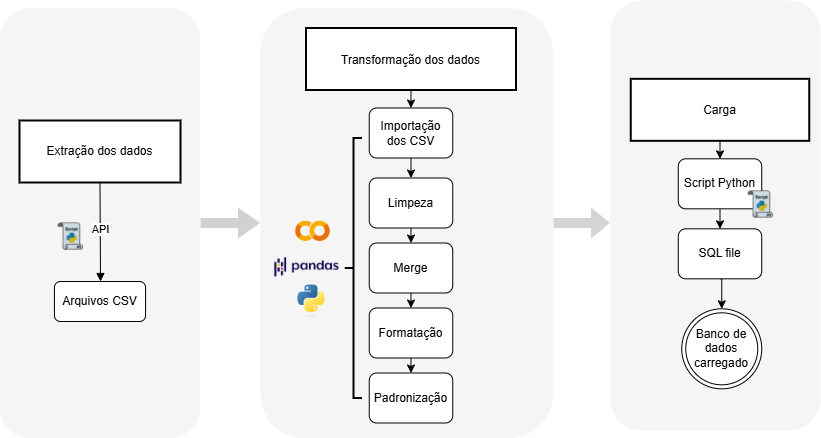

#### Importação dos dados

Os dados serão importados dos arquivos `.csv` e analisados.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Caminhos para os arquivos CSV
caminho_tabela_fipe_base = 'https://raw.githubusercontent.com/BeatrizPat/Tabela-Fipe-DW/refs/heads/main/tabela_fipe_base.csv'
caminho_dados_carro = 'https://raw.githubusercontent.com/BeatrizPat/Tabela-Fipe-DW/refs/heads/main/tabela-fipe-historico-precos.csv'
caminho_dados_caminhao = 'https://raw.githubusercontent.com/BeatrizPat/Tabela-Fipe-DW/refs/heads/main/dados_caminhao-20-21.csv'
caminho_dados_moto = 'https://raw.githubusercontent.com/BeatrizPat/Tabela-Fipe-DW/refs/heads/main/dados_moto-20-21.csv'

try:
  # Importando os arquivos CSV usando pandas
  tabela_fipe_base = pd.read_csv(caminho_tabela_fipe_base)
  dados_carro = pd.read_csv(caminho_dados_carro)
  dados_caminhao = pd.read_csv(caminho_dados_caminhao)
  dados_moto = pd.read_csv(caminho_dados_moto)

except FileNotFoundError:
  print(f"Erro: Um ou mais arquivos CSV não foram encontrados. Verifique os caminhos especificados.")
except pd.errors.EmptyDataError:
  print(f"Erro: Um ou mais arquivos CSV estão vazios.")
except pd.errors.ParserError:
    print(f"Erro: Um ou mais arquivos CSV possuem um formato inválido.")
except Exception as e:
  print(f"Ocorreu um erro inesperado: {e}")

In [ ]:
# Excluindo a coluna Preço
tabela_fipe_base = tabela_fipe_base.drop('Preço', axis=1)

# Imprime a quantidade total de dados
print(f"\nQuantidade total de dados: {len(tabela_fipe_base)}")

# Agrupa por tipo de veículo e conta a quantidade de cada categoria
vehicle_counts = tabela_fipe_base.groupby('Tipo')['Tipo'].count()
vehicle_counts


Quantidade total de dados: 43936


,Tipo
Tipo,
Caminhão,9835
Carro,26850
Moto,7251


#### Merge dos dados

Os dados foram extraídos da fonte nos arquivos abaixo:

* `tabela_fipe_base.csv`
* `tabela_fipe_historico_preco.csv`
* `dados_caminhao-20-21.csv`
* `dados_moto-20-21.csv`

O primeiro arquivo contém os dados completos de cada modelo, incluindo tipo, marca, ano-modelo e tipo de combustível.

Já o segundo arquivo contém os dados referente a variação do preço dos carros ao longo dos anos para cada modelo, com dados de 1/2001 até 8/2022.

Por fim, os dois últimos arquivos contêm a variação do preço de caminhões e motos no período 2020-2021.

Para compor o DW, faremos um merge desses arquivos e manter somente os dados de 2020-2021.

##### Carro

In [ ]:
# Renomeia as colunas para o merge com df e descarta as não utilizadas
dados_carro = dados_carro.rename(columns={
    'marca': 'Marca',
    'modelo': 'Modelo',
    'anoModelo': 'Ano',
    'codigoFipe': 'Código FIPE',
    'valor': 'Preço'
})
dados_carro = dados_carro.iloc[:, 1:]
tabela_fipe_base = tabela_fipe_base.drop('Mês de Referência', axis=1)

# Merge dos carros com a tabela base
tabela_fipe_carro = pd.merge(dados_carro, tabela_fipe_base, on=['Código FIPE', 'Ano'], how='inner')

# Ajuste das colunas
tabela_fipe_carro = tabela_fipe_carro.drop(['Marca_y', 'Modelo_y', 'Sigla Combustível'], axis=1)
tabela_fipe_carro = tabela_fipe_carro.rename(columns={
    'Tipo_x': 'Tipo',
    'Marca_x': 'Marca',
    'Modelo_x': 'Modelo',
    'mesReferencia': 'mesReferencia',
    'anoReferencia': 'anoReferencia'
})
tabela_fipe_carro = tabela_fipe_carro[['Tipo', 'Marca', 'Modelo', 'Ano', 'Código FIPE', 'Combustível', 'mesReferencia', 'anoReferencia', 'Preço']]

# Filtra o DataFrame para manter apenas as linhas com anoReferencia igual a 2020 ou 2021
tabela_fipe_carro = tabela_fipe_carro[tabela_fipe_carro['anoReferencia'].isin([2020, 2021])]


##### Caminhão

In [ ]:
# Cria as colunas 'mesReferencia' e 'anoReferencia'
dados_caminhao[['mesReferencia', 'anoReferencia']] = dados_caminhao['Mês de Referência'].str.split(' de ', expand=True)

# Converte a coluna 'mesReferencia' para numérico, tratando os meses por extenso
def mes_para_numero(mes):
    meses = {
        'janeiro': 1, 'fevereiro': 2, 'março': 3, 'abril': 4, 'maio': 5, 'junho': 6,
        'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12
    }
    return meses.get(mes.lower(), None)

dados_caminhao['mesReferencia'] = dados_caminhao['mesReferencia'].apply(mes_para_numero)

# Converte a coluna 'anoReferencia' para numérico
dados_caminhao['anoReferencia'] = pd.to_numeric(dados_caminhao['anoReferencia'])

# Remove a antiga coluna 'Mês de Referência'
dados_caminhao = dados_caminhao.drop('Mês de Referência', axis=1)

# Merge dos carros com a tabela base
tabela_fipe_caminhao = pd.merge(dados_caminhao, tabela_fipe_base, on=['Código FIPE', 'Ano'], how='inner')

# Ajuste das colunas
tabela_fipe_caminhao = tabela_fipe_caminhao.drop(['Modelo_y', 'Sigla Combustível'], axis=1)
tabela_fipe_caminhao = tabela_fipe_caminhao.rename(columns={
    'Modelo_x': 'Modelo',
    'mesReferencia': 'mesReferencia',
    'anoReferencia': 'anoReferencia'
})
tabela_fipe_caminhao = tabela_fipe_caminhao[['Tipo', 'Marca', 'Modelo', 'Ano', 'Código FIPE', 'Combustível', 'mesReferencia', 'anoReferencia', 'Preço']]

print(tabela_fipe_caminhao.head())

       Tipo   Marca                             Modelo    Ano Código FIPE  \
0  Caminhão  AGRALE   14000 / 14000 S 2p (diesel) (E5)  32000    501030-6   
1  Caminhão  AGRALE   14000 / 14000 S 2p (diesel) (E5)  32000    501030-6   
2  Caminhão  AGRALE  10000 / 10000 S  2p (diesel) (E5)   2021    501034-9   
3  Caminhão  AGRALE  10000 / 10000 S  2p (diesel) (E5)   2021    501034-9   
4  Caminhão  AGRALE  10000 / 10000 S  2p (diesel) (E5)   2021    501034-9   

  Combustível  mesReferencia  anoReferencia          Preço  
0      Diesel              8           2021  R$ 309.400,00  
1      Diesel             12           2020  R$ 258.400,00  
2      Diesel             11           2021  R$ 181.681,00  
3      Diesel              5           2021  R$ 169.988,00  
4      Diesel              4           2021  R$ 171.221,00  


##### Moto

In [ ]:
# Cria as colunas 'mesReferencia' e 'anoReferencia'
dados_moto[['mesReferencia', 'anoReferencia']] = dados_moto['Mês de Referência'].str.split(' de ', expand=True)

# Converte a coluna 'mesReferencia' para numérico, tratando os meses por extenso
def mes_para_numero(mes):
    meses = {
        'janeiro': 1, 'fevereiro': 2, 'março': 3, 'abril': 4, 'maio': 5, 'junho': 6,
        'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12
    }
    return meses.get(mes.lower(), None)

dados_moto['mesReferencia'] = dados_moto['mesReferencia'].apply(mes_para_numero)

# Converte a coluna 'anoReferencia' para numérico
dados_moto['anoReferencia'] = pd.to_numeric(dados_moto['anoReferencia'])

# Remove a antiga coluna 'Mês de Referência'
dados_motos = dados_moto.drop('Mês de Referência', axis=1)

# Merge das motos com a tabela base
tabela_fipe_motos = pd.merge(dados_motos, tabela_fipe_base, on=['Código FIPE', 'Ano'], how='inner')

# Ajuste das colunas
tabela_fipe_moto = tabela_fipe_motos.drop(['Modelo_y', 'Sigla Combustível'], axis=1)
tabela_fipe_moto = tabela_fipe_motos.rename(columns={
    'Modelo_x': 'Modelo',
    'mesReferencia': 'mesReferencia',
    'anoReferencia': 'anoReferencia'
})
tabela_fipe_moto = tabela_fipe_moto[['Tipo', 'Marca', 'Modelo', 'Ano', 'Código FIPE', 'Combustível', 'mesReferencia', 'anoReferencia', 'Preço']]

print(tabela_fipe_motos.head())

  Código FIPE Modelo_x   Ano        Preço  mesReferencia  anoReferencia  Tipo  \
0    840015-6  ATV 100  2002  R$ 3.860,00             10           2021  Moto   
1    840015-6  ATV 100  2002  R$ 3.704,00              7           2021  Moto   
2    840015-6  ATV 100  2002  R$ 3.807,00              9           2021  Moto   
3    840014-8   ATV 50  2001  R$ 2.718,00             11           2021  Moto   
4    840014-8   ATV 50  2001  R$ 2.672,00              6           2020  Moto   

  Marca Modelo_y Combustível Sigla Combustível  
0  ADLY  ATV 100    Gasolina                 G  
1  ADLY  ATV 100    Gasolina                 G  
2  ADLY  ATV 100    Gasolina                 G  
3  ADLY   ATV 50    Gasolina                 G  
4  ADLY   ATV 50    Gasolina                 G  


#### Concatenação dos dados de Carro, Caminhão e Moto

In [ ]:
# Concatena os DataFrames tabela_fipe_carro e tabela_fipe_caminhao
tabela_fipe = pd.concat([tabela_fipe_carro, tabela_fipe_caminhao, tabela_fipe_moto], ignore_index=True)
tabela_fipe.size

855090

#### Eliminação de dados nulos

In [ ]:
total_nulls = tabela_fipe.isnull().sum().sum()
print(f"\nTotal de valores nulos no DataFrame: {total_nulls}")
print(tabela_fipe.isnull().sum())


Total de valores nulos no DataFrame: 0
Tipo             0
Marca            0
Modelo           0
Ano              0
Código FIPE      0
Combustível      0
mesReferencia    0
anoReferencia    0
Preço            0
dtype: int64


#### Formatação dados
* O atributo `Preço` será convertido de "R$ X.XXX,YY" para decimal.
* Formatação da coluna `mesReferencia` e `anoReferencia` para a coluna `DataReferencia` no formato `01-MM-AAA`


In [ ]:
def convert_price(price_str, vehicle_type):
    if vehicle_type == 'Carro':
        try:
            return float(price_str)
        except ValueError:
            return None
    else:
        try:
            price_str = price_str.replace('R$ ', '').replace('.', '').replace(',', '.')
            return float(price_str)
        except ValueError:
            return None

def convert_to_date_string(row):
  try:
    return f"01-{int(row['mesReferencia']):02d}-{row['anoReferencia']}"
  except (ValueError, TypeError):
    return None

# Aplicando as funções
tabela_fipe['Preço'] = tabela_fipe.apply(lambda row: convert_price(row['Preço'], row['Tipo']), axis=1)
tabela_fipe['DataReferencia'] = tabela_fipe.apply(convert_to_date_string, axis=1)
tabela_fipe = tabela_fipe.drop(['anoReferencia', 'mesReferencia'], axis=1)

#### Padronização / Categorização
* Na dimensão `Versão`, o atributo `Combustível` será categorizado da seguinte forma: G (Gasolina), E (Etanol), F (Flex), H (Híbrido), D (Diesel), X (Elétrico).
* Padronizar os valores de texto em campos como "Marca" e "Modelo" para maiusculas ou minúsculas e remover espaços extras ou caracteres especiais.


In [ ]:
def codifica_combustivel(fuel_type):
    if pd.isna(fuel_type):
        return None
    fuel_type = fuel_type.upper()
    if 'GASOLINA' in fuel_type:
        return 'G'
    elif 'ÁLCOOL' in fuel_type:
        return 'A'
    elif 'FLEX' in fuel_type:
        return 'F'
    elif 'HIBRIDO' in fuel_type:
        return 'H'
    elif 'DIESEL' in fuel_type:
        return 'D'
    elif 'ELETRICO' in fuel_type:
        return 'X'
    else:
        return fuel_type

def padronizar_texto(df, colunas):
  for coluna in colunas:
    df[coluna] = df[coluna].str.strip().str.upper()
  return df

# Aplicando as funções
tabela_fipe['Combustível'] = tabela_fipe['Combustível'].apply(codifica_combustivel)
tabela_fipe = padronizar_texto(tabela_fipe, ['Marca', 'Modelo'])

In [ ]:
print(tabela_fipe['Combustível'].unique())

['G' 'A' 'D']


In [ ]:
tabela_fipe

,Tipo,Marca,Modelo,Ano,Código FIPE,Combustível,Preço,DataReferencia
0,Carro,ACURA,INTEGRA GS 1.8,1992,038003-2,G,11750.0,01-12-2021
1,Carro,ACURA,LEGEND 3.2/3.5,1998,038002-4,G,25128.0,01-08-2020
2,Carro,ACURA,INTEGRA GS 1.8,1992,038003-2,G,11710.0,01-11-2021
3,Carro,ACURA,NSX 3.0,1995,038001-6,G,40607.0,01-10-2020
4,Carro,ACURA,INTEGRA GS 1.8,1992,038003-2,G,11499.0,01-09-2021
...,...,...,...,...,...,...,...,...
95005,Moto,AGRALE,TCHAU 50,1996,801019-6,G,1304.0,01-02-2020
95006,Moto,AGRALE,TCHAU 50,1995,801019-6,G,1214.0,01-02-2020
95007,Moto,AGRALE,SXT 27.5 EX 190CC,1991,801018-8,G,1874.0,01-04-2020
95008,Moto,AGRALE,TCHAU 50,1995,801019-6,G,1211.0,01-03-2020


## 5. Carga

##### Script para fazer a carga

In [ ]:
# Nome do arquivo SQL de saída
output_file = "insert_script_fipe.sql"

# Nome da tabela PostgreSQL
table_name = "dados_fipe"

# Gerar os comandos INSERT
with open(output_file, "w", encoding="utf-8") as f:
    f.write("""
    -- Insere os dados no banco de dados após o ETL

      CREATE TABLE """+ table_name +""" (
          id SERIAL PRIMARY KEY,
          tipo VARCHAR(50) NOT NULL,
          marca VARCHAR(100) NOT NULL,
          modelo VARCHAR(100) NOT NULL,
          ano INTEGER NOT NULL,
          preco DECIMAL(10,2) NOT NULL,
          codigoFIPE VARCHAR(20) NOT NULL,
          dataReferencia DATE NOT NULL,
          combustivel VARCHAR(50) NOT NULL
      );
    """)
    for _, row in tabela_fipe.iterrows():
        values = [
            "'" + row['Tipo'].replace("'", "''") + "'",
            "'" + row['Marca'].replace("'", "''") + "'",
            "'" + row['Modelo'].replace("'", "''") + "'",
            str(row['Ano']),  # Ano como inteiro
            str(row['Preço']),  # Preço como decimal
            "'" + row['Código FIPE'].replace("'", "''") + "'",
            "'" + row['DataReferencia'] + "'",  # Data já no formato adequado
            "'" + row['Combustível'].replace("'", "''") + "'"
        ]

        sql = f"INSERT INTO {table_name} (tipo, marca, modelo, ano, preco, codigoFIPE, dataReferencia, combustivel) VALUES ({', '.join(values)});\n"
        f.write(sql)

print(f"Arquivo '{output_file}' gerado com sucesso!")


Arquivo 'insert_script_fipe.sql' gerado com sucesso!


##### DW
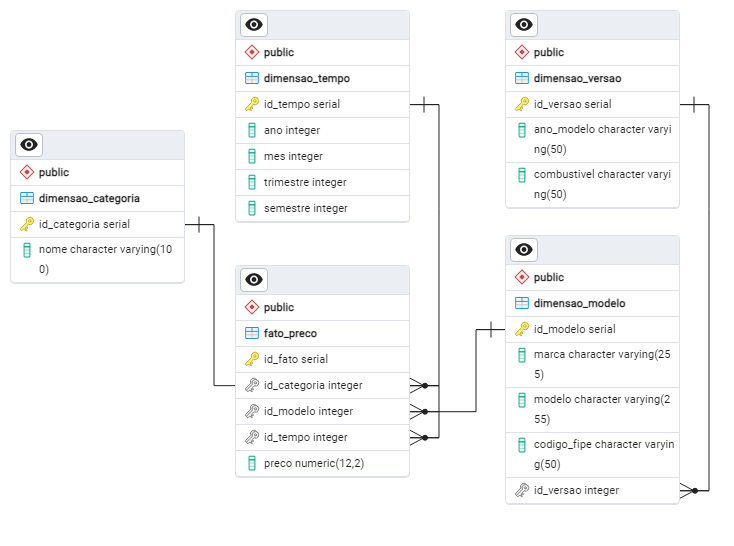

## 6. OLAP + Visualização

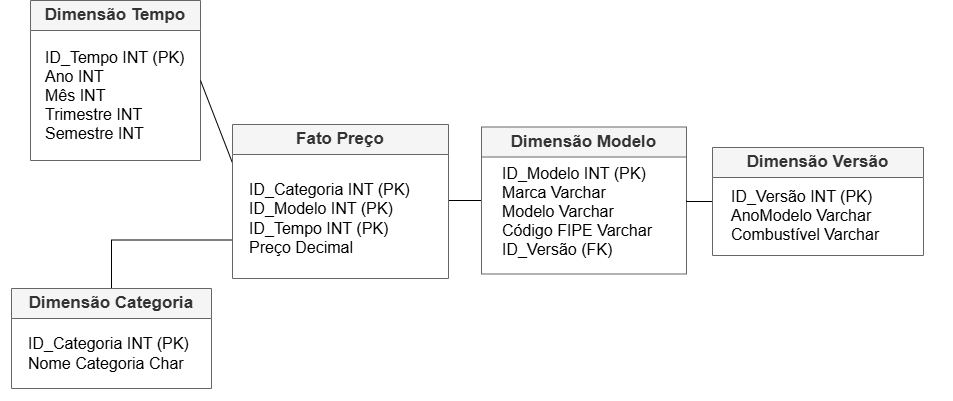

Após popular o banco de dados `dados_fipe` com as inserções geradas e implementar o modelo de *Data Warehouse* correspondente à ilustração acima, nós então pudemos realizar a migração dos dados, utilizando uma conexão `DBLink` para transferir os do banco original para o banco DW.

#### Implementação das análises

* Qual foi a variação percentual do preço de determinado modelo em um período?

```sql
WITH preco_inicial AS (
    SELECT
        fp.preco AS preco,
        dv.ano_modelo AS ano_modelo
    FROM fato_preco fp
    JOIN dimensao_modelo dm ON fp.ID_modelo = dm.ID_modelo
    JOIN dimensao_tempo dt ON fp.ID_tempo = dt.ID_tempo
    JOIN dimensao_versao dv ON dm.ID_versao = dv.ID_versao
    WHERE dm.nome_modelo = 'ELEFANTRE 30.0 ES 190CC'
      AND dt.ano = 2020
      AND dt.mes = 1
),
preco_final AS (
    SELECT
	    fp.preco AS preco,
        dv.ano_modelo AS ano_modelo
    FROM fato_preco fp
    JOIN dimensao_modelo dm ON fp.ID_modelo = dm.ID_modelo
    JOIN dimensao_tempo dt ON fp.ID_tempo = dt.ID_tempo
	JOIN dimensao_versao dv ON dm.ID_versao = dv.ID_versao
    WHERE dm.nome_modelo = 'ELEFANTRE 30.0 ES 190CC'
      AND dt.ano = 2021
      AND dt.mes = 12
)
SELECT
    pi.ano_modelo,
    ((pf.preco - pi.preco) / pi.preco * 100) AS variacao_percentual
FROM
    preco_inicial pi
JOIN preco_final pf ON pi.ano_modelo = pf.ano_modelo
ORDER BY pi.ano_modelo;
```


Foi escolhido o modelo de moto **ELEFANTRE 30.0 ES 190cc** da marca **Agrale**. Retornando os preços de cada ano-modelo para **janeiro** de **2020** e fazendo a comparação (variação percentual) desses preços para **dezembro** de **2021**.

Preços em janeiro de 2020:

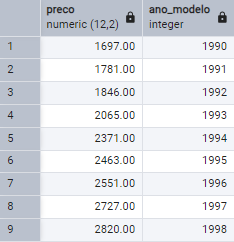

Preços em dezembro de 2021:

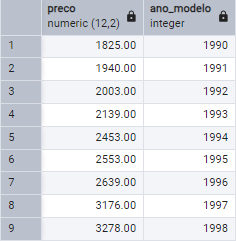

Variação percentual do preço de cada ano-modelo entre janeiro de 2020 para dezembro de 2021:

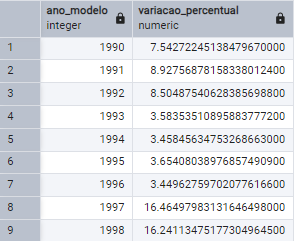

####Gráfico ilustrando os aumentos percentuais nos preços:

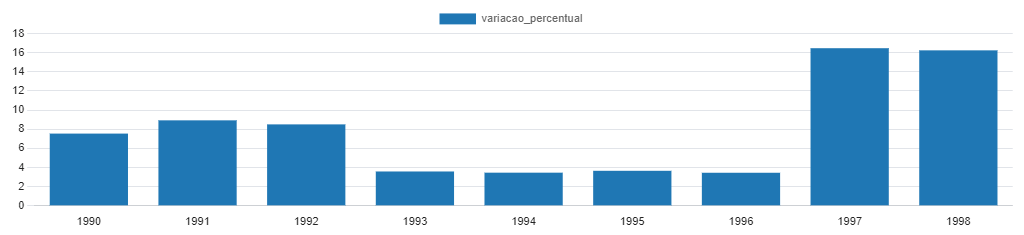

É possível notar que para todos os `ano-modelo` desse modelo de moto, os preços apenas aumentaram, principalmente nos `ano-modelo` de 1997 e 1998.

####Outro modelo:

```sql
SELECT
    marca, nome_modelo, ano_modelo, preco, mes, ano
FROM
    fato_preco fp
JOIN
    dimensao_modelo dm ON fp.ID_modelo = dm.ID_modelo
JOIN
    dimensao_tempo dt ON fp.ID_tempo = dt.ID_tempo
JOIN
    dimensao_versao dv on dm.ID_versao = dv.ID_versao
WHERE
    dm.nome_modelo = 'GOL RALLYE I MOTION 1.6 T. FLEX 16V 5P'
ORDER BY
    dt.ano, dt.mes;
```

Ao observar um modelo específico de carro com seus preços de todos os meses de referência de 2020 até 2021, nota-se essas mudanças de preço:

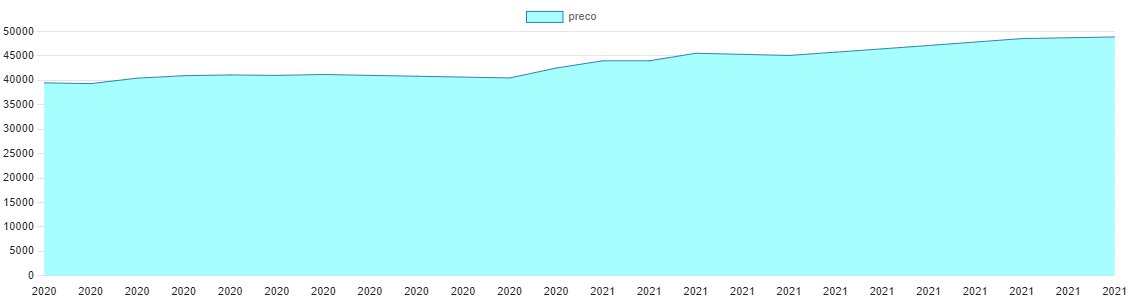



```sql
WITH precos_mensais AS (
    SELECT dm.marca, dm.nome_modelo, dv.ano_modelo, fp.preco, dt.mes, dt.ano
    FROM fato_preco fp JOIN dimensao_modelo dm ON fp.ID_modelo = dm.ID_modelo
    JOIN dimensao_tempo dt ON fp.ID_tempo = dt.ID_tempo
    JOIN dimensao_versao dv ON dm.ID_versao = dv.ID_versao
    WHERE dm.nome_modelo = 'GOL RALLYE I MOTION 1.6 T. FLEX 16V 5P' AND dt.ano BETWEEN 2020 AND 2021
    ORDER BY dt.ano, dt.mes
),
precos_com_lag AS (
    SELECT marca, nome_modelo, ano_modelo, preco, mes, ano, LAG(preco) OVER (ORDER BY ano, mes) AS preco_anterior
    FROM precos_mensais
)
SELECT marca, nome_modelo, ano_modelo, preco, mes, ano,
    CASE WHEN preco_anterior IS NOT NULL
    THEN ROUND(((preco - preco_anterior) / preco_anterior) * 100, 2)
    ELSE NULL
    END AS aumento_percentual
FROM precos_com_lag
ORDER BY ano, mes;
```



Consulta para gerar variações percentuais a cada mês de janeiro de 2020 até dezembro de 2021.

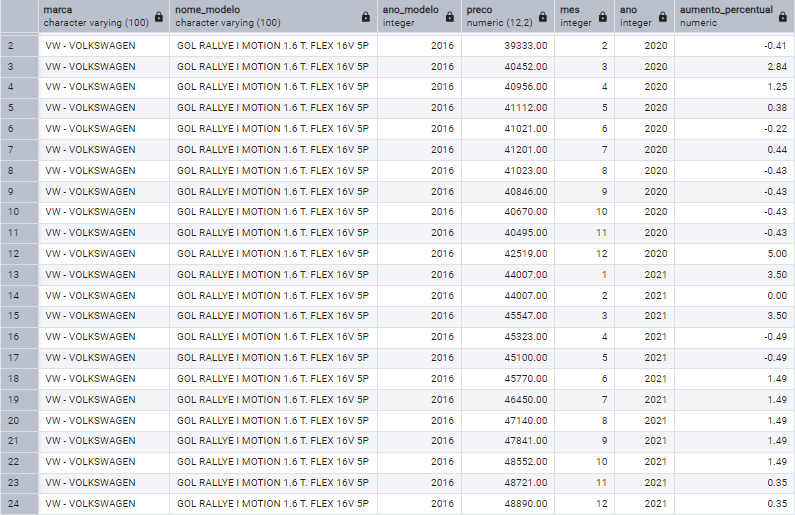

Um leve aumento progressivo nos preços do modelo **"GOL RALLYE I MOTION 1.6 T. FLEX 16V 5P"** da marca **"VW - VOLKSWAGEN"**, no seu único (disponível no banco) `ano-modelo` de 2016 entre janeiro de 2020 até dezembro de 2021. Em alguns meses, os preços diminuem um pouco, de repente aumentam. Porém, de modo geral, observa-se um aumento progressivo nos preços.

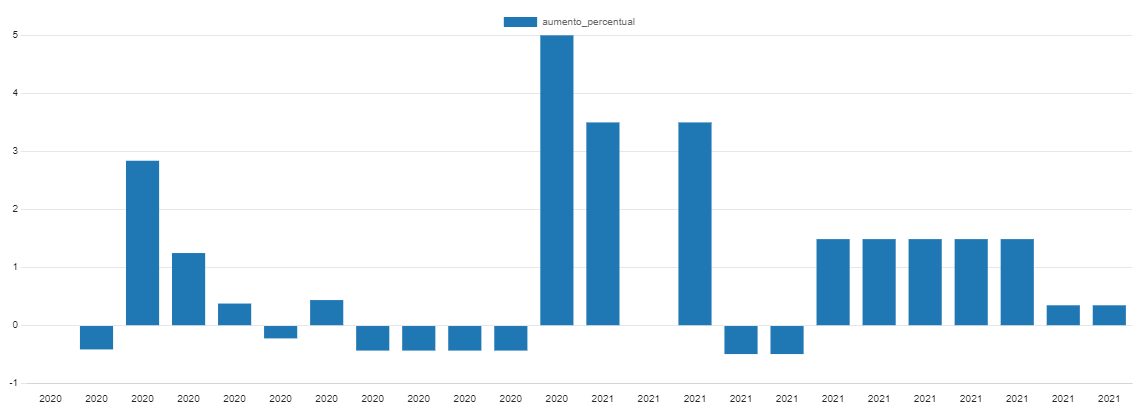

### Qual a média de preço dos veículos da marca x no ano y?




Escolhendo a marca **Rolls-Royce** e seu preço médio em 2020 e 2021, observamos:

```sql
SELECT
    dm.marca,
    AVG(fp.Preco) AS preco_medio_2020
FROM
    fato_preco fp
JOIN
    dimensao_modelo dm ON fp.ID_modelo = dm.ID_modelo
JOIN
    dimensao_tempo dt ON fp.ID_tempo = dt.ID_tempo
WHERE
    dm.marca = 'ROLLS-ROYCE' AND dt.ano = 2020
GROUP BY
    dm.marca;
```
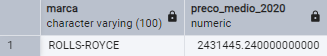
```sql
SELECT
    dm.marca,
    AVG(fp.Preco) AS preco_medio_2021
FROM
    fato_preco fp
JOIN
    dimensao_modelo dm ON fp.ID_modelo = dm.ID_modelo
JOIN
    dimensao_tempo dt ON fp.ID_tempo = dt.ID_tempo
WHERE
    dm.marca = 'ROLLS-ROYCE' AND dt.ano = 2021
GROUP BY
    dm.marca;
```

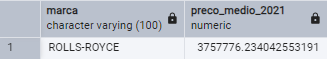

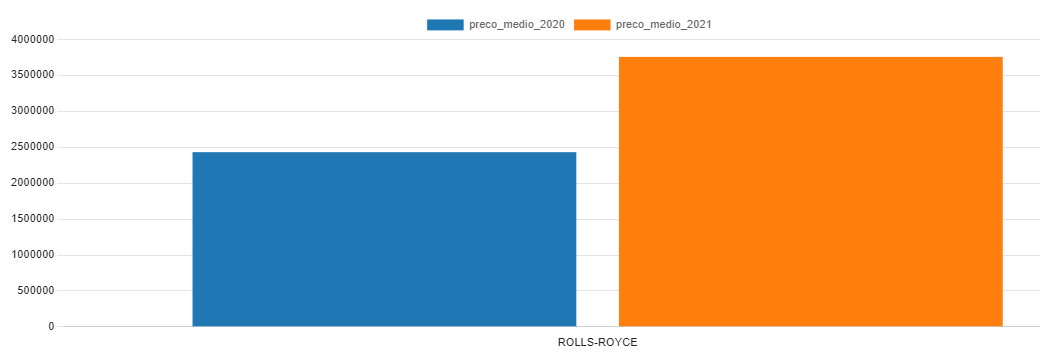

Nota-se que o preço médio dessa marca era **2.431.445,24 BRL** em 2020 e subiu para **3.757.776,23 BRL** em 2021.

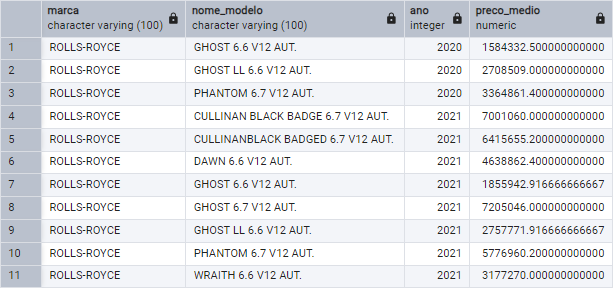

Esses são os preços médios por modelo da marca *Rolls-Royce* nos anos de 2020 e 2021. Nos dados coletados, estão disponíveis 3 modelos em 2020 e 8 em 2021.

## 7. Backup do DW

[Backup disponibilizado no GitHub](https://github.com/BeatrizPat/Tabela-Fipe-DW/raw/9b2690a5734a7183004e8fb2969489caf9a6efaf/Backup%20DW/backup_dw.sql)


## 8. Considerações Finais

Como mencionado anteriormente, desenvolvemos um *script* em Python para coletar dados da API do site oficial da Tabela FIPE, utilizando requisições HTTP simuladas.

Inicialmente, coletamos os dados de um mês de referência fixo, no qual foram armazenadas as informações de preço e código FIPE de todos os anos-modelo dos veículos disponíveis. Esses dados abrangem todos os modelos das marcas, considerando os três tipos de veículos analisados.

Devido ao volume significativo de dados para apenas um mês de referência (43.936 registros), ao tentarmos executar o *script* para coletar informações de vários meses, visando atingir o objetivo inicial do *Data Warehouse* (DW), percebemos que o processo de *Web Scraping* levaria dias. Isso porque, para um único mês, o processo já consumiu aproximadamente 20 horas.

Considerando que existem três tipos de veículos, cada um com diversas marcas, modelos e anos modelo diferentes, a multiplicação dessas variáveis pelos meses de referência tornaria a obtenção de todos os dados inviável.

Para tentar agilizar o processo, exploramos alternativas como o uso de múltiplas *threads* utilizando a biblioteca *concurrent.futures* do Python, para permitir distribuir a carga de trabalho entre vários *workers*, executando tarefas de forma concorrente. Também tentamos reduzir os tempos de espera para coleta de dados. Essas duas alternativas gerou bloqueios nas requisições pela API (erro 429).

Assim, ao tentar coletar os dados dos caminhões e das motos, com esses bloqueios da API, vários registros foram pulados, o que resultou em uma variedade maior de modelos e marcas, porém uma quantidade menor de dados.

Portanto, para os dados dos caminhões e motos, pudemos obter poucos registros. Já para os carros, encontramos uma fonte de dados em um projeto no *Kaggle* [2] que foi capaz de nos ajudar a obter o objetivo desse projeto ao fornecer quantidade suficiente de dados.

No final, escolhemos os meses do ano de 2020 e 2021 para poder juntar com os dados de caminhões e motos. Nesse *notebook*, na seção de *Web Scraper* está o exemplo usado para coletar os dados dos caminhões, também utilizamos um alternativo para as motos.

## 9. Referências

1. [Tabela FIPE - Site Oficial](https://veiculos.fipe.org.br/)
2. [Tabela FIPE - Kaggle Dataset](https://www.kaggle.com/datasets/franckepeixoto/tabela-fipe)
3. [Tipos de Dados DECIMAL - Neon Tech](https://neon.tech/docs/data-types/decimal)
4. [Outriggers - IBM Documentation](https://www.ibm.com/docs/en/ida/9.1?topic=models-outriggers)
5. [API Fipe](https://veiculos.fipe.org.br/api/veiculos//)


